In [1]:
import os
import glob
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from tqdm import tqdm
import time
from scanpy.tools._utils import get_init_pos_from_paga 
from sklearn.metrics import mean_squared_error
import warnings

import torch
import rmm
import cupy
import cudf
import cupy as cp
from rmm.allocators.cupy import rmm_cupy_allocator
import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
import scvi

from cuml.manifold import UMAP
from cuml.decomposition import TruncatedSVD

# Enable `managed_memory`
rmm.reinitialize(
    managed_memory=True,
    pool_allocator=False,
)
cp.cuda.set_allocator(rmm_cupy_allocator)

from tqdm.notebook import tqdm

In [2]:
%%time
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/pseudotime.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 285 ms, sys: 3.21 s, total: 3.49 s
Wall time: 7.33 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra

# Recompute PCA on Imputed Embeddings

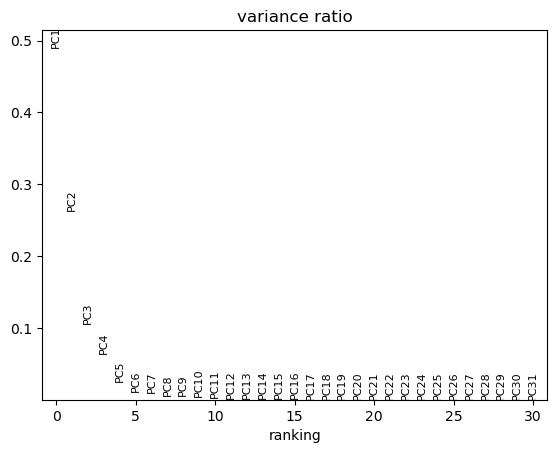

CPU times: user 497 ms, sys: 280 ms, total: 777 ms
Wall time: 853 ms


In [3]:
%%time
rsc.get.anndata_to_GPU(adata)
rsc.pp.pca(adata, layer='scvi')

sc.pl.pca_variance_ratio(adata)

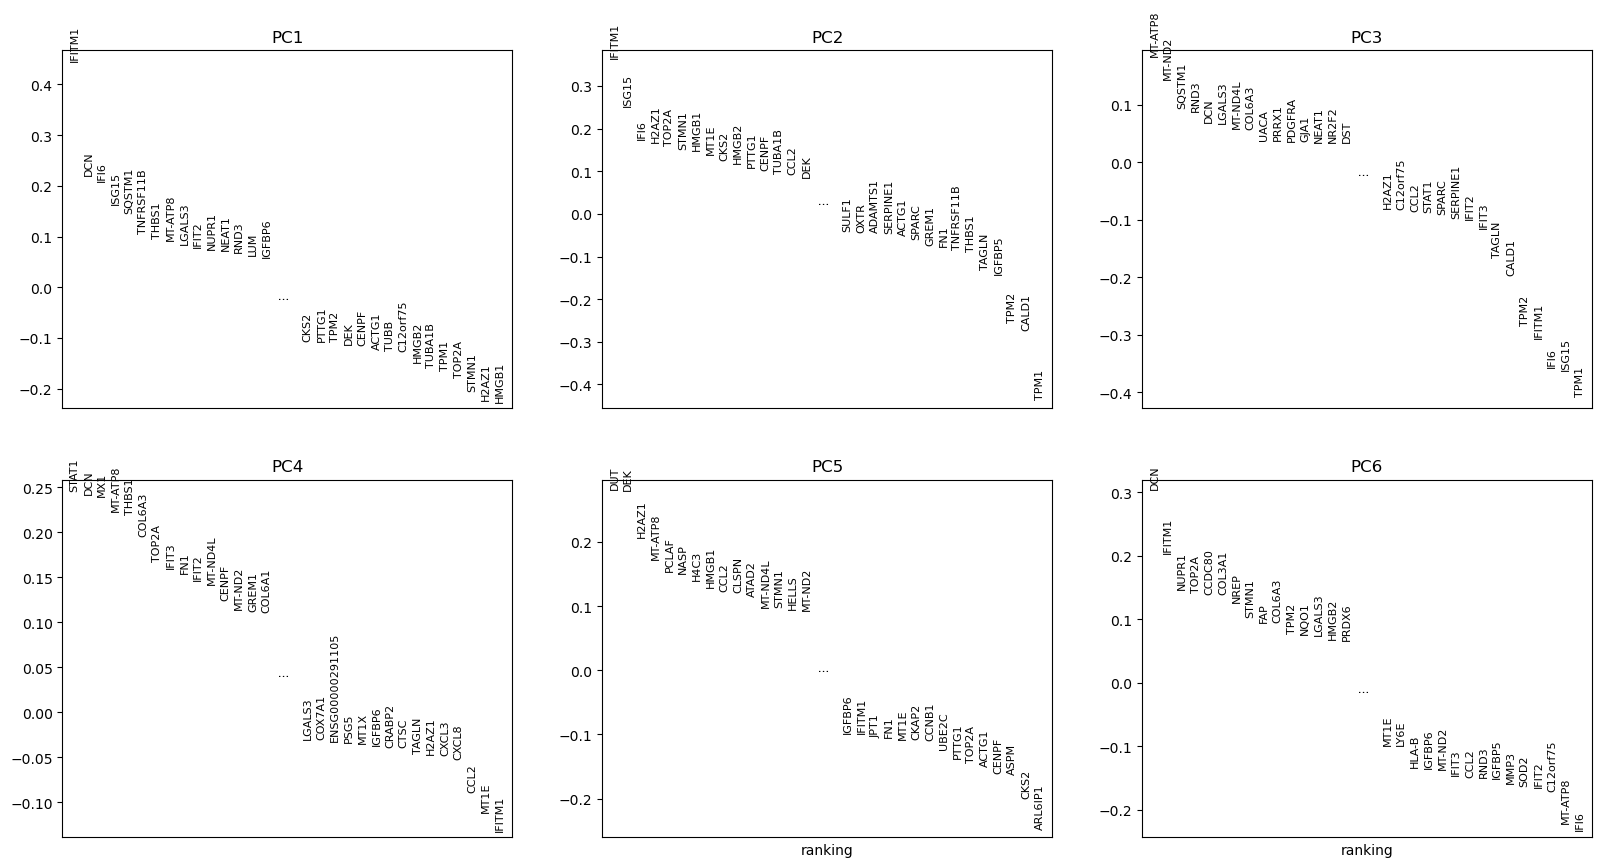

In [4]:
sc.pl.pca_loadings(
    adata,
    components=[1, 2, 3, 4, 5, 6]
)

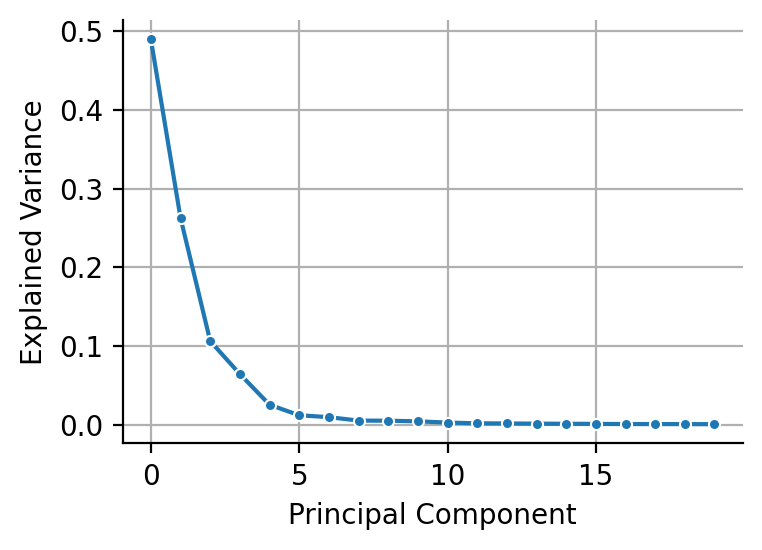

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.75

n = 20

sns.lineplot(
    adata.uns['pca']['variance_ratio'][:n],
    marker="o",
    markersize=4,
)
plt.grid(True)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
sns.despine()

# Scree Plot

🔹 Using 50 components...
🔹 Loading data onto GPU...
   Matrix shape: (6895, 15906), dtype=float32

🔹 Initializing Truncated SVD (k=35)...
🔹 Fitting SVD model and transforming data...
   Latent representation shape (Z): (6895, 50)
   Components shape (VT): (50, 15906)
   Singular values (length 50):


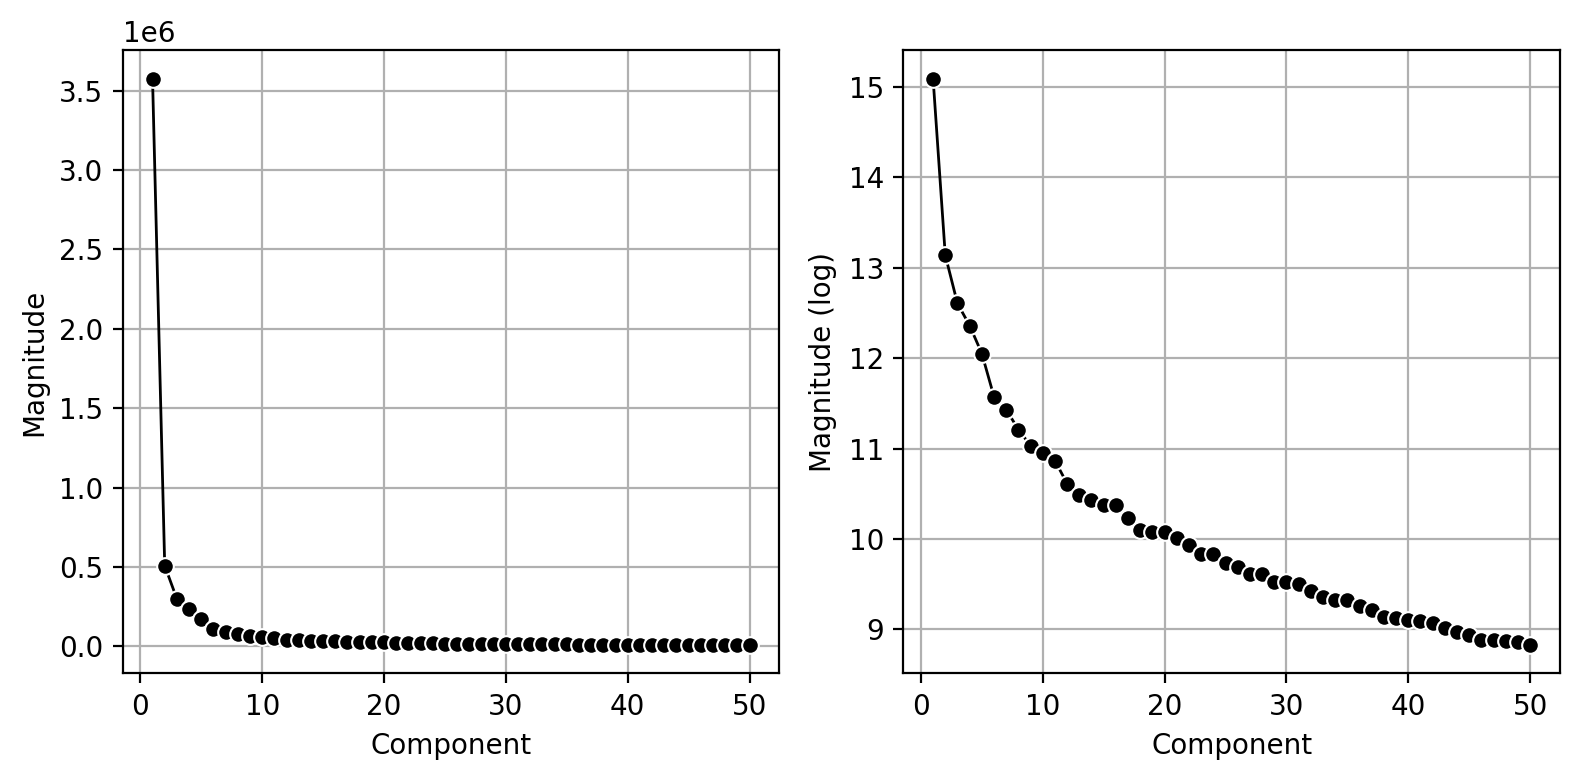

CPU times: user 5.46 s, sys: 4.86 s, total: 10.3 s
Wall time: 10.3 s


In [6]:
%%time 
components = 50
print(f"🔹 Using {components} components...")
print("🔹 Loading data onto GPU...")
X = cp.asarray(adata.layers['scvi'], dtype=cp.float32)
print(f"   Matrix shape: {X.shape}, dtype={X.dtype}")

print("\n🔹 Initializing Truncated SVD (k=35)...")
svd = TruncatedSVD(
    n_components=components,
    n_iter=7,
    random_state=0,
)

print("🔹 Fitting SVD model and transforming data...")
Z = svd.fit_transform(X)
print(f"   Latent representation shape (Z): {Z.shape}")

VT = svd.components_
print(f"   Components shape (VT): {VT.shape}")

S = svd.singular_values_
print(f"   Singular values (length {len(S)}):")

# Ensure singular values are NumPy
S_cpu = cp.asnumpy(S)

df = pd.DataFrame({
    "Component": range(1, len(S_cpu) + 1),
    "SingularValue": S_cpu,
    "SingularValue_log": np.log(S_cpu)
})

# Two-column subplot
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharex=True)

sns.lineplot(data=df, x="Component", y="SingularValue",
             lw=1, marker="o", color="k", ax=axes[0])
axes[0].set_xlabel("Component")
axes[0].set_ylabel("Magnitude")
axes[0].grid(True)

sns.lineplot(data=df, x="Component", y="SingularValue_log",
             lw=1, marker="o", color="k", ax=axes[1])
axes[1].set_xlabel("Component")
axes[1].set_ylabel("Magnitude (log)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


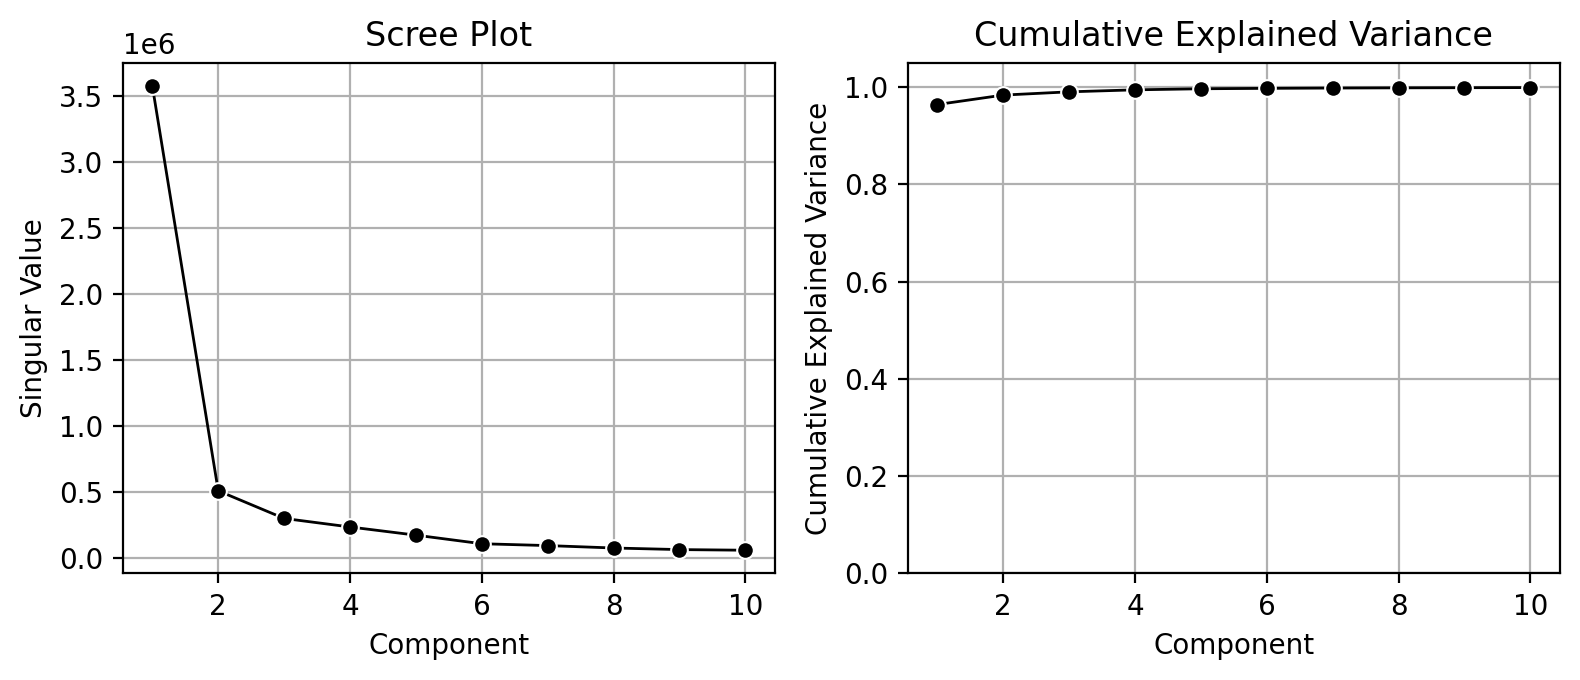

In [7]:
n = 10

# Ensure singular values are NumPy
S_cpu = cp.asnumpy(S)

df = pd.DataFrame({
    "Component": range(1, len(S_cpu) + 1),
    "SingularValue": S_cpu,
})

# Compute explained variance and cumulative
total_var = (df["SingularValue"] ** 2).sum()
df["ExplainedVariance"] = (df["SingularValue"] ** 2) / total_var
df["CumulativeVariance"] = df["ExplainedVariance"].cumsum()

df = df.head(n)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), dpi=200)

# Scree plot
sns.lineplot(
    x="Component", y="SingularValue",
    marker="o", lw=1, color="k", data=df, ax=axes[0]
)
axes[0].set_xlabel("Component")
axes[0].set_ylabel("Singular Value")
axes[0].set_title("Scree Plot")
axes[0].grid(True)

# Cumulative explained variance
sns.lineplot(
    x="Component", y="CumulativeVariance",
    marker="o", lw=1, color="k", data=df, ax=axes[1]
)
axes[1].set_xlabel("Component")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("Cumulative Explained Variance")
axes[1].set_ylim(0, 1.05)
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Reconstruction Error

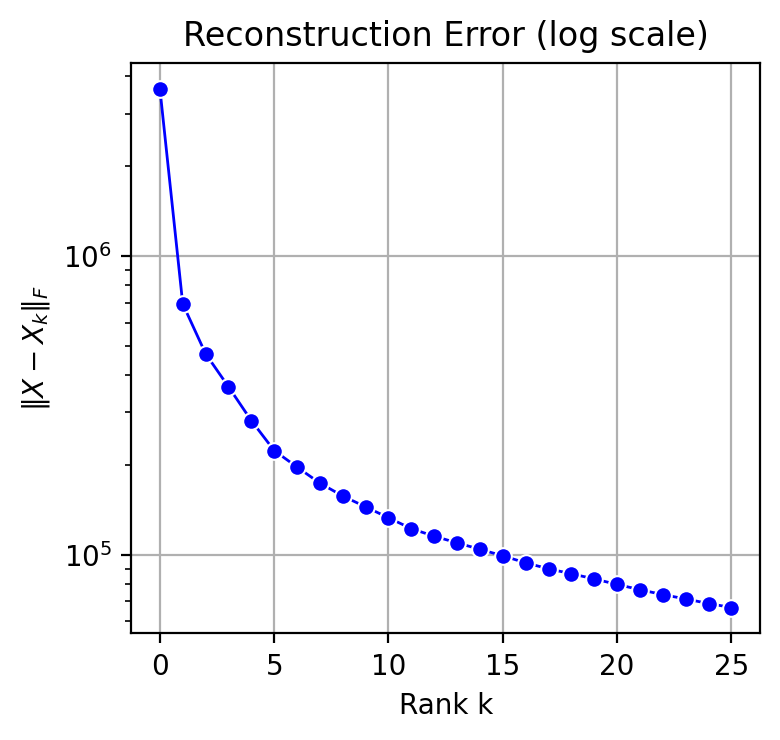

CPU times: user 258 ms, sys: 27.9 ms, total: 286 ms
Wall time: 312 ms


In [8]:
%%time
# --- Reconstruction error vs rank k (uses projection energy) ---
# Frobenius norm^2 of original matrix
total_norm2 = float(cp.linalg.norm(X, ord='fro')**2)

# Energy captured by each component = sum of squares of projected data (columns of Z)
comp_energy = cp.sum(Z**2, axis=0)                      # shape: (components,)
cum_energy = cp.cumsum(comp_energy)                     # cumulative captured energy

# --- Restrict to first 10 components ---
max_k = 25
ks = np.arange(0, max_k + 1)  # include k=0

cum_energy_cpu = np.concatenate(([0.0], cp.asnumpy(cum_energy[:max_k])))
err2 = total_norm2 - cum_energy_cpu
err = np.sqrt(np.maximum(err2, 0.0))
rel_err = err2 / total_norm2

err_df = pd.DataFrame({
    "k": ks,
    "FrobeniusError": err,
    "UnexplainedVariance": rel_err
})

# --- Plots ---
fig, axes = plt.subplots(1, 1, figsize=(4, 3.8), dpi=200)

sns.lineplot(
    data=err_df, x="k", y="FrobeniusError",
    marker="o", lw=1, ax=axes, color="b"
)
axes.set_title("Reconstruction Error (log scale)")
axes.set_xlabel("Rank k")
axes.set_ylabel(r"$\|X - X_k\|_F$")
axes.set_yscale("log")
axes.grid(True)

plt.tight_layout()
plt.show()


# Better Reconstruction?

/nfs/turbo/umms-indikar/Cooper/conda_envs/rapids/lib/python3.13/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[scvi] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: GPU available: True (cuda), used: True
2025-09-03 15:17:11 | [INFO] GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-09-03 15:17:11 | [INFO] TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-09-03 15:17:11 | [INFO] HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-09-03 15:17:11 | [INFO] Y

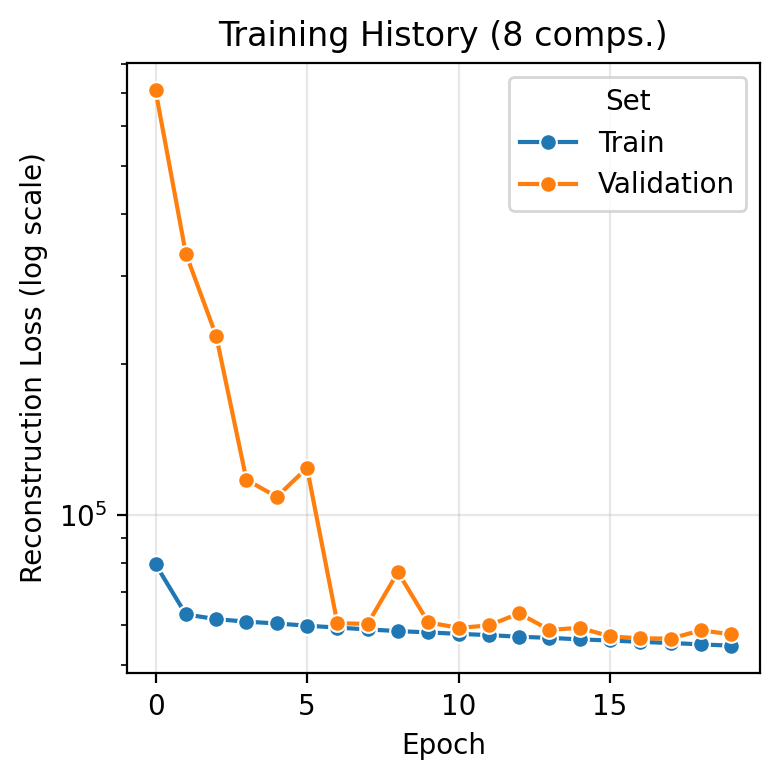

CPU times: user 12.4 s, sys: 583 ms, total: 12.9 s
Wall time: 13.1 s


In [9]:
%%time

components = 8

# Setup & train
rsc.get.anndata_to_CPU(adata)
scvi.model.SCVI.setup_anndata(adata, layer="scvi")
model = scvi.model.SCVI(adata, n_latent=components)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # suppress all warnings
    model.train(
        max_epochs=20,
        check_val_every_n_epoch=1,  # run validation every epoch
        plan_kwargs={"lr": 1e-3},
        enable_progress_bar=False,
    )

history = model.history

# history is a dict
train = np.asarray(history["reconstruction_loss_train"]).squeeze()
val   = np.asarray(history["reconstruction_loss_validation"]).squeeze()

# Epoch index just matches the length
epoch = np.arange(len(train))

df = pd.DataFrame({
    "Epoch": epoch,
    "Train": train,
    "Validation": val,
})

df_long = df.melt(id_vars="Epoch", var_name="Set", value_name="ReconstructionLoss")

# Plot
plt.rcParams["figure.dpi"] = 200
plt.figure(figsize=(4, 4))
sns.lineplot(
    data=df_long,
    x="Epoch",
    y="ReconstructionLoss",
    hue="Set",
    marker="o"
)

plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (log scale)")
plt.title(f"Training History ({components} comps.)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
def decode_from_z(model, z, library_size=1e4, batch_index=0, adjust_zero_inflation=False):
    """
    Return per-gene expected expression from latent z.
    If adjust_zero_inflation=True, returns (1 - pi) * mu, where pi = sigmoid(zi_logits).
    """
    model.module.eval()
    device = model.device
    with torch.no_grad():
        z_t   = torch.as_tensor(z, dtype=torch.float32, device=device)
        libln = torch.full((z_t.shape[0], 1), float(np.log(library_size)), device=device)
        b_t   = torch.full((z_t.shape[0],), int(batch_index), dtype=torch.long, device=device)

        out = model.module.generative(z_t, libln, b_t, cont_covs=None, cat_covs=None)
        px  = out["px"]  # ZeroInflatedNegativeBinomial

        mu = px.mu                       # NB mean (library * scale)
        if adjust_zero_inflation:
            pi = torch.sigmoid(px.zi_logits)   # zero-inflation prob
            mu = (1.0 - pi) * mu               # expected observed counts

        return mu.detach().cpu().numpy()

# Example usage
Z = model.get_latent_representation()

# Decode observed embeddings (first 5)
expr_recon = decode_from_z(model, Z[:5], library_size=1e4)               # shape (5, n_genes)

# Decode new embeddings
z_new = np.random.randn(3, model.module.n_latent)
expr_new = decode_from_z(model, z_new, library_size=1e4, adjust_zero_inflation=True)

# Top genes in synthetic cell 0
genes = np.asarray(adata.var_names)
top = np.argsort(-expr_new[0])[:10]
print(list(zip(genes[top], expr_new[0, top])))

# 4A) Decode the first 5 real embeddings back to expression
expr_recon = decode_from_z(model, Z[:5], library_size=1e4)   # (5 × genes)
print("Reconstructed expression for cells 0–4:", expr_recon.shape)


[('IFITM3', np.float32(204.00139)), ('S100A6', np.float32(188.21538)), ('LGALS1', np.float32(174.63562)), ('RPL35', np.float32(136.55574)), ('TMSB10', np.float32(128.53426)), ('RPLP2', np.float32(125.45517)), ('RPL28', np.float32(117.26083)), ('RPL30', np.float32(113.17889)), ('MT2A', np.float32(110.69656)), ('RPS19', np.float32(110.50893))]
Reconstructed expression for cells 0–4: (5, 15906)


In [11]:
# pick a set of observed cells (same as your Z[:5] example)
cells_idx = np.arange(10)

# decode with ZINB expectation to compare to counts
expr_recon = decode_from_z(
    model, Z[cells_idx], library_size=1e4, batch_index=0, adjust_zero_inflation=True
)  # shape: (n_cells, n_genes)

# get observed counts for the same cells from the 'scvi' layer (fallback to X if needed)
X_obs = adata.layers["scvi"][cells_idx, :] if "scvi" in adata.layers else adata.X[cells_idx, :]
X_obs = X_obs.A if sp.issparse(X_obs) else np.asarray(X_obs)

# per-gene MSE across the selected cells
mse_gene = ((X_obs - expr_recon) ** 2).mean(axis=0)

genes = np.asarray(adata.var_names)
order = np.argsort(mse_gene)

least10 = order[:10]
most10  = order[-10:][::-1]

print("Overall MSE (these cells):", float(((X_obs - expr_recon) ** 2).mean()))

print("\n10 least MSE (most similar):")
print(pd.DataFrame({"gene": genes[least10], "mse": mse_gene[least10]}).to_string(index=False))

print("\n10 most MSE (least similar):")
print(pd.DataFrame({"gene": genes[most10], "mse": mse_gene[most10]}).to_string(index=False))


Overall MSE (these cells): 125490.046875

10 least MSE (most similar):
           gene      mse
          MMP13 4.102431
ENSG00000286511 5.629855
ENSG00000236924 5.818198
ENSG00000289463 6.652915
ENSG00000228470 6.738543
        TMEM102 7.004167
ENSG00000290606 7.004206
        SMANTIS 7.146825
ENSG00000267939 7.225588
ENSG00000224363 7.237678

10 most MSE (least similar):
  gene         mse
LGALS1 133989456.0
TMSB10 114438016.0
 RPLP1 112681944.0
S100A6  97710000.0
  MT2A  88198936.0
 RPL28  63337480.0
IFITM3  45900432.0
MALAT1  43965664.0
RPL37A  42568468.0
 TIMP1  33507920.0
